In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from zodipy._source_funcs import get_phase_function
from zodipy.source_params import PHASE_FUNCTION_DIRBE, SPECTRUM_DIRBE

from zodipol.mie_scattering.particle_size_model import ParticleSizeModel
from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipol.visualization.mie_plotting import plot_mueller_matrix_elems
from zodipol.zodipol.zodipol import MIE_MODEL_DEFAULT_PATH

In [3]:
wavelength = SPECTRUM_DIRBE[:3].to('nm').value  # in nm
C = list(zip(*PHASE_FUNCTION_DIRBE))[:3]
C_w = dict(zip(wavelength.round().astype(int), C))
C_w = {1250: C_w[1250]}

In [4]:

def distance_from_kelsall(theta, func, c):
    kelsall_125um = get_phase_function(theta, c)
    bhat = bhat_distance(theta, func, kelsall_125um)
    return bhat


def bhat_distance(theta, func1, func2):
    bhat_distance = -np.log(2*np.pi*np.trapz(np.sqrt(func1 * func2) * np.sin(theta), theta))
    return bhat_distance


def scattering_dop(mueller):
    dop = mueller[..., 0, 1] / mueller[..., 0, 0]
    return np.max(abs(dop))


def optimization_cost(s_min, s_max, big_gamma, small_gamma):
    psm = ParticleSizeModel(s_min=s_min, s_max=s_max, big_gamma=big_gamma, small_gamma=small_gamma, s_res=200)  # create a particle size model
    mie = MieScatteringModel.train(spectrum, particle_size=psm)  # train a Mie scattering model

    # plot the model
    dop = []
    dist_from_kesall = []
    for w in C_w:
        mueller_125um = mie.get_mueller_matrix(np.array(w), theta)  # get the scattering
        mie_phase_func_125um = mueller_125um[..., 0, 0, 0]
        cur_dist_from_kesall = distance_from_kelsall(theta, mie_phase_func_125um, c=C_w[w])
        dist_from_kesall.append(cur_dist_from_kesall)
        dop.append(scattering_dop(mueller_125um))

    mean_dist = np.mean(dist_from_kesall)
    return mean_dist, np.mean(dop)

In [77]:
spectrum = np.logspace(np.log10(300), np.log10(3500), 10)  # white light wavelength in nm
theta = np.linspace(0, np.pi, 100)  # angle in radians

# create a parameter mapping
s_min = np.logspace(np.log10(0.1), np.log10(0.1), 1)  # in um
s_max = np.logspace(np.log10(10), np.log10(10), 1)  # in um
big_gamma = np.linspace(1, 1, 1)
small_gamma = np.linspace(2, 4, 11)
BG, SG, SN, SX = np.meshgrid(big_gamma, small_gamma, s_min, s_max)  # create a grid of parameters
SN, SX, BG, SG = SN.flatten(), SX.flatten(), BG.flatten(), SG.flatten()  # flatten the grid

In [78]:
parameter_mapping = pd.DataFrame({'s_min': SN, 's_max': SX, 'big_gamma': BG, 'small_gamma': SG})  # create a dataframe from the grid
print(f'Number of models to train: {len(parameter_mapping)}')
parameter_mapping  # show the dataframe

Number of models to train: 11


,s_min,s_max,big_gamma,small_gamma
0,1.0,10.0,1.0,2.0
1,1.0,10.0,1.0,2.2
2,1.0,10.0,1.0,2.4
3,1.0,10.0,1.0,2.6
4,1.0,10.0,1.0,2.8
5,1.0,10.0,1.0,3.0
6,1.0,10.0,1.0,3.2
7,1.0,10.0,1.0,3.4
8,1.0,10.0,1.0,3.6
9,1.0,10.0,1.0,3.8


In [79]:
iterator = tqdm(parameter_mapping.iterrows(), total=len(parameter_mapping))
results = []
for ind, row in iterator:
    # create a Mie scattering model
    dist_kelsall, polariz = optimization_cost(s_min=row['s_min'], s_max=row['s_max'], big_gamma=row['big_gamma'],
                            small_gamma=row['small_gamma'])

    row_dict = row.to_dict()
    row_dict['dist_from_kesall'] = dist_kelsall
    row_dict['polarization'] = polariz
    results.append(row_dict)
    iterator.set_description(", ".join([f"{k}: {row_dict[k]: .3f}" for k in row_dict]))

s_min:  1.000, s_max:  10.000, big_gamma:  1.000, small_gamma:  2.200, dist_from_kesall:  0.939, polarization:  0.958:  18%|█▊        | 2/11 [03:14<14:35, 97.24s/it]


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
# results_df.dist_from_kesall = -results_df.dist_from_kesall
results_df

<Axes: xlabel='dist_from_kesall', ylabel='polarization'>

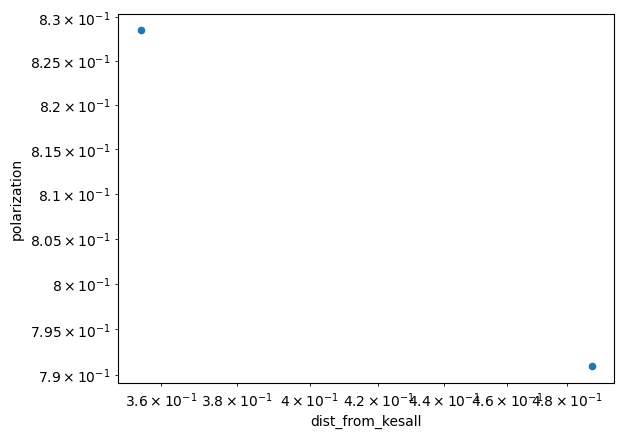

In [14]:
results_df.plot.scatter(x='dist_from_kesall', y='polarization', grid=True, loglog=True)

In [15]:
best_res = results_df.loc[results_df.polarization.argmin()]
best_res

s_min                0.010000
s_max               10.000000
big_gamma            1.000000
small_gamma          2.000000
dist_from_kesall     0.488514
polarization         0.790959
Name: 0, dtype: float64

## Plot the best results

In [11]:
spectrum = np.logspace(np.log10(300), np.log10(1300), 10)  # white light wavelength in nm
theta = np.linspace(0, np.pi, 100)  # angle in radians

In [12]:
def generate_model(x, spectrum):
    s_min, s_max, big_gamma, small_gamma = x[5], x[6], 1, x[7]
    refractive_index_dict = {x[0] + 1j * x[1]: 1-x[4], x[2] + 1j * x[3]: x[4]}
    psm = ParticleSizeModel(s_min=s_min, s_max=s_max, big_gamma=big_gamma, small_gamma=small_gamma,
                            s_res=200)  # create a particle size model
    mie = MieScatteringModel.train(spectrum, particle_size=psm,
                                   refractive_index_dict=refractive_index_dict)  # train a Mie scattering model
    return mie

In [ ]:
# Good parameters
# [4.83162, 0.07339, 2.87939, 0.00212, 0.21977, 0.1054, 0.64525, 1.78187]
# [6.13981, 0.08286, 3.0199, 0.00178, 0.20205, 0.10339, 0.75284, 1.766]

In [129]:
x = [6.11175, 0.08278, 3.07128, 0.00182, 0.20079, 0.10301, 0.75446, 1.74194]
mie = generate_model(x, spectrum)

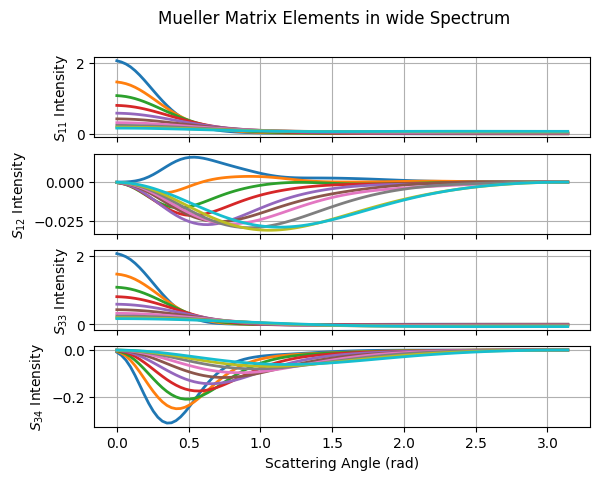

In [130]:
# recreate best results model and plot (full spectrum)
mie_scatt = mie(spectrum, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3], title='Mueller Matrix Elements in wide Spectrum')

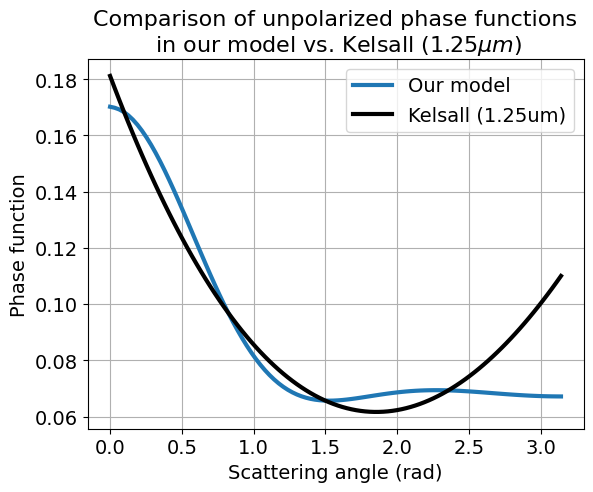

In [131]:
# Compare to Kelsall's model
mie_scatt = mie(1250, theta)
kelsall_125um = get_phase_function(theta, C_w[1250])

plt.figure()
plt.plot(theta, mie_scatt[:, :, 0, 0], lw=3, label='Our model')
plt.plot(theta, kelsall_125um, 'k', lw=3, label='Kelsall (1.25um)')
plt.title('Comparison of unpolarized phase functions\n in our model vs. Kelsall ($1.25\mu m$)', fontsize=16)
plt.xlabel('Scattering angle (rad)', fontsize=14)
plt.ylabel('Phase function', fontsize=14)
plt.grid()
plt.legend(prop={'size': 14})
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.savefig('outputs/mie_kelsall_model_compare.pdf', format='pdf')
plt.show()

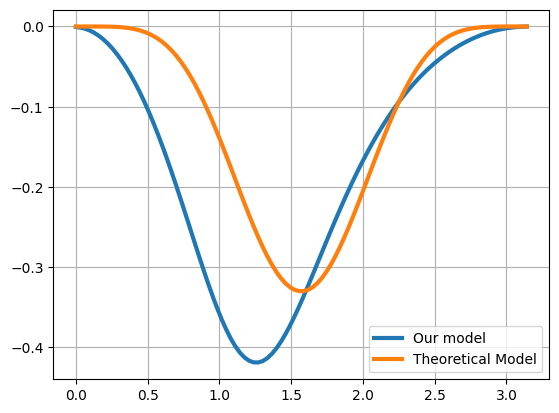

In [132]:
plt.figure()
plt.plot(theta, mie_scatt[:, :, 0, 1]/mie_scatt[:, :, 0, 0], lw=3, label='Our model')
plt.plot(theta, -0.33*np.sin(theta)**5, lw=3, label='Theoretical Model')
plt.legend()
plt.grid()
plt.show()

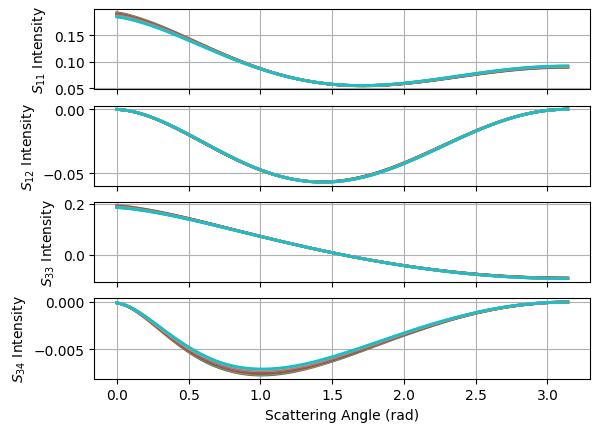

In [9]:
# Display out model in the White Light spectrum
spectrum_wl = np.logspace(np.log10(300), np.log10(700), 10)  # white light wavelength in nm
psm = ParticleSizeModel(s_min=best_res['s_min'], s_max=best_res['s_max'], big_gamma=best_res['big_gamma'], small_gamma=best_res['small_gamma'])  # create a particle size model
mie = MieScatteringModel.train(spectrum_wl, particle_size=psm)
mie_scatt = mie(spectrum_wl, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3], title='Mueller Matrix Elements in the Visible Spectrum')

In [100]:
# save the new Mie model
from zodipol.zodipol.zodipol import MIE_MODEL_DEFAULT_PATH
mie.save(MIE_MODEL_DEFAULT_PATH)
print(MIE_MODEL_DEFAULT_PATH)

saved_models/white_light_mie_model.npz
